# Overview

This workbook consist of two parts; a customer segmentation analysis and a customer life time value prediction. 
A customer segmentation analysis is crucial for business in order to identify and understand their customers needs and behaviors. If Olist wants to take direct actions in order to increase the revenue of customers then it needs to take different actions based on the different needs the customers might have. 


## KPI and metrics

A range of Key Performance Indicators (KPIs) are defined for Olist to directly measure the value of the analysis and keep track of performance. The following three KPIs are identified iteratively through the analysis and are relevant for Olist when analysing customer segments and customer life time value.

- `Monthly revenue` For an online retailer, the most important metric to keep track of is the monthly revenue. If the revenue decreases over months then it suggest that Olist are losing customers and they need to take action asap. If the Revenue is increasing over months then Olist should seek to understand what underlying factors in the business are driving the revenue and how can this be further maximised.

- `Customer Lifetime Value` In this analysis customers are clustered into three categories high, mid, and low, in terms of their Customer Lifetime Value (CLV). Keeping track of the amount of customers in each of the categories is crucial for Olist. In the end Olist might want to change this distribution i.e. move customers from low and mid to high CLV. Which they can set targets for using a CLV KPI. This will be further explained later in the notebook.

- `Repeat Customer Rate` Number of returning customers on Olist i.e. customers who make multiple purchases.

In [47]:
# Import
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import datetime as dt
warnings.filterwarnings('ignore')
%matplotlib inline

dirpath = '../data/'

### Import of data 

The workbook will focus on the customer part of the OLIST dataset. Therefore, only the following datasets are joined:

- olist_customers_dataset
- olist_order_payments_dataset
- olist_orders_dataset

These are joined by the left-join operation and dataformat is set. 

In [48]:
# Load data
customers = pd.read_csv(dirpath+"olist_customers_dataset.csv")
order_payments = pd.read_csv(dirpath+"olist_order_payments_dataset.csv")
orders = pd.read_csv(dirpath+"olist_orders_dataset.csv")

# Join
customer_order = customers.merge(orders, on='customer_id', how='left')
order_payments = order_payments.groupby('order_id').sum().reset_index()[['order_id','payment_value']]
cop = customer_order.merge(order_payments, on='order_id', how='left')

# clean and format
cop['order_purchase_timestamp'] = pd.to_datetime(cop['order_purchase_timestamp'])
cop = cop[cop['order_status']!='canceled']

cop.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,252.25


### Data exploring and visualisation
For an online reatiler, the most important metric to keep track of is the monthly revenue. If the revenue decreases over months then it suggest that Olist are losing customers and they need to take action asap. If the Revenue is increasing over months then Olist should seek to understand what underlying factors in the business are driving the revenue and how can this be further maximised.

In the following section, a couple of plots and tables are defined in order to understand the current performance of Olist. These are defined in the list below:

- Monthly revenue 
- Monthy growth rate
- Number of active customers each month
- Number of returning customers each month/quarter



In [49]:
#Monthly revenue
cop['PurchaseMonth'] = cop['order_purchase_timestamp'].map(lambda date: 100*date.year + date.month)
cop_MonthlyRevenue  = cop.groupby(['PurchaseMonth'])['payment_value'].sum().reset_index()
cop_MonthlyRevenue.head()

,PurchaseMonth,payment_value
0,201609,136.23
1,201610,53915.50
2,201612,19.62
3,201701,138119.76
4,201702,289081.01


In [50]:
#Finding the quarterly revenue and plotting that (fewer datapoints to visualise)
cop['quarter'] = pd.PeriodIndex(cop.order_purchase_timestamp, freq='Q')
cop_revenue  = cop.groupby(['quarter'])['payment_value'].sum().reset_index()
cop_revenue

,quarter,payment_value
0,2016Q3,136.23
1,2016Q4,53935.12
2,2017Q1,869607.14
3,2017Q2,1505678.59
4,2017Q3,1976337.10
5,2017Q4,2835290.94
6,2018Q1,3250497.95
7,2018Q2,3328040.12
8,2018Q3,2046093.33


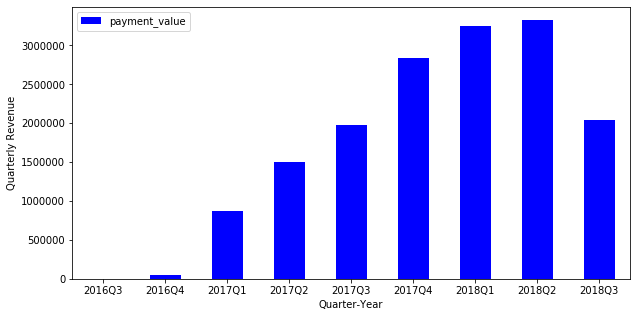

In [51]:
ax = cop_revenue.plot.bar(x='quarter', y='payment_value', rot=0, figsize=(10,5), color='b')
plt.xlabel('Quarter-Year')
plt.ylabel('Quarterly Revenue')
plt.show()

The quarterly revenue has been growing throughout the period except in the lastest quarter. 
Below the growth rate is calculated by calculating the difference between the previous month and current month.

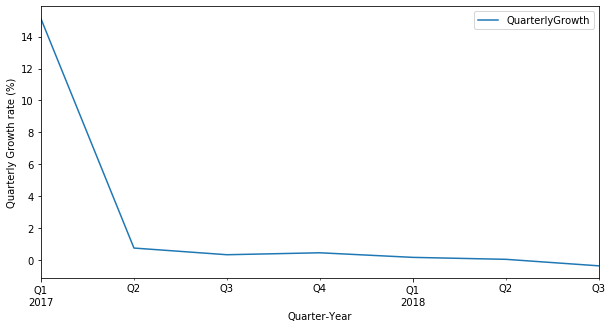

In [52]:
#calculating the quarterly growthrate and plotting it
cop_revenue['QuarterlyGrowth'] = cop_revenue['payment_value'].pct_change()

cop_revenue[2:].plot(x='quarter',y='QuarterlyGrowth',figsize=(10,5))
plt.xlabel('Quarter-Year')
plt.ylabel('Quarterly Growth rate (%)')
plt.show()

In [53]:
cop_revenue['QuarterlyGrowth']

0           NaN
1    394.912207
2     15.123208
3      0.731447
4      0.312589
5      0.434619
6      0.146442
7      0.023855
8     -0.385196
Name: QuarterlyGrowth, dtype: float64

The growth rate is declining for Olist throughout the observed period.

In [54]:
customer_order.groupby('customer_unique_id').size().count()

96096

In [55]:
# Distribution of how many times customers are returning to buy at Olist
customer_order.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

In [56]:
#number of non-returning customers in the dataset
(93099/customer_order.groupby('customer_unique_id').size().count())*100

96.88124375624375

This suggest that Olist has a huge problem with non-returning customers. 
Returning customers are essential for a business to create growth and stay above water. 
As described in the KPI section in the start of the notebook, we can calculate a repeat customer rate, RCR , which is a metric Olist can measure their performance with.

This is calculated by $RCR =\frac{\sum_{p \in P}Unique \ Customers}{All \ unique \ Customers} $, where $P$ is the number of customers with a frequency higher or equal to 2 purchases. 

In [57]:
Sum_Customer_P = len(cop[cop.customer_unique_id.isin(list(unique_id[unique_id.customer_id > 1].index))])
AllUniqueCustomers = cop.customer_unique_id.count()

RCF = (Sum_Customer_P/AllUniqueCustomers)*100
print("The RCR is: ",RCF)

The RCR is:  6.25404792746114


As expected the current RCR rate is extremely low at 6.25%. 

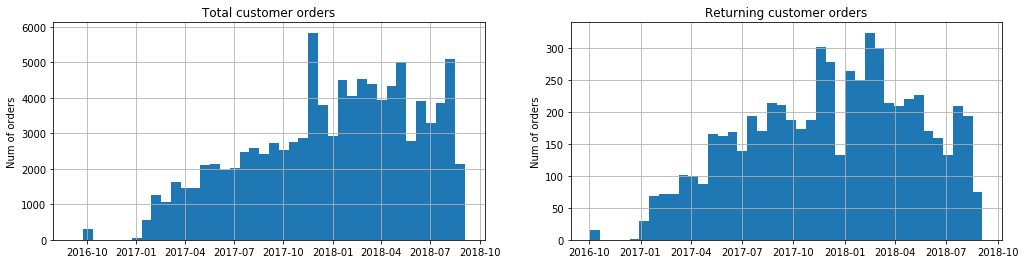

In [58]:
# The total customer order per month  and the amount of returning orders are visualised in the two plots below. 
plt.figure(figsize=(17, 4))

plt.subplot(1, 2, 1)
plt.title('Total customer orders')
plt.ylabel('Num of orders')
cop.order_purchase_timestamp.hist(bins=40)

plt.subplot(1, 2, 2)
plt.ylabel('Num of orders')
plt.title('Returning customer orders')
unique_id = cop.groupby('customer_unique_id').count()
later_purchase = cop[cop.customer_unique_id.isin(list(unique_id[unique_id.customer_id > 1].index))]
later_purchase.order_purchase_timestamp.hist(bins=40)
plt.show()

#savefig('subplotCust',bbox_inches='tight')

In [59]:
len(later_purchase)

6180

### Customer Segmentation
In this report, the Recency-Frequency-Monetary (RFM) - clustering method has been chosen. The RFM method is used to analyse the value of a customer by the following three dimensions :

 - Recency: How recently did the customer purchase?  This is measured as number of days since the customer last     bought an item on Olist 
 
 - Frequency: How often do they purchase? The higher value, the more engaged the customers are on Olist
 
 - Monetary: How much do they spend? This is the total amount of money that the customers have spend on Olist
 
Each customer will get a combined RFM score.



The three parts of RFM is calculated now. The data is grouped by the unique customer id.
Recency is calculated with the difference between the lastest purchasing date in the data set subtracted with the purchase date of the observation.
Frequency is calculated by counting the amount of purchase timestamps each customer have. 
Revenue is calculated by summing each customer's payment_value. 


In [60]:
# Recency
df_recency = cop.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_recency.columns = ['customer_unique_id','last_purchase_date']
df_recency['Recency'] = (df_recency['last_purchase_date'].max() - df_recency['last_purchase_date']).dt.days
df_recency = df_recency[['customer_unique_id','Recency']]

# Frequency
df_frequency = cop.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_unique_id','Frequency']

# Revenue
df_revenue = cop.groupby('customer_unique_id').payment_value.sum().reset_index()
df_revenue.columns = ['customer_unique_id','Revenue']

df = pd.DataFrame(cop['customer_unique_id'].unique())
df.columns = ['customer_unique_id']

### K-Means clustering
We are going to apply K-means clustering to assign a score for each dimension in RFM. 
K-means clustering is a type of unsupervised machine learning algorithms which gives K clusters based on distance. Distance is measured by two factors. 
 - _Within clusters sums of squares_ (WSS) is the sum of distances between each point in the cluster and the corresponding centroid. Given by the formula: $WSS = \sum_{i}^{N_c} \sum_{x\in C_i} d(x,\overline{x}_{C_i})^2$
 - _Between clusters sum of squares_ (BSS) is the sum of distances between the centroids and the total sample mean mulitplied by the number of points within each cluster. Given by the formula: $BSS = \sum_{i}^{N_c} |C_{i}| \cdot d(\overline{x}_{C_i},\overline{x})^2$
 
where $C_{i}=Cluster_i, N_c = N\ \#\ Clusters,\ \overline{x}_{C_i}\ and\ \overline{x} = Sample\ mean$ 

K-means algorithm seeks to get the optimised points for the centorid by moving and iterating the cluster centroids to minimise the value of WSS and maximise the value of BSS.



K-means require that we specify K clusters. This can be done from the Elbow method which tells us the optimal number of clusters. First we define a function named plot_cluster which creates a for loop and calculate the a kmeans clustering for $K=\{1..10\}$. The function is called below and shows the optimal number of clusters is 4 for 'Recency'. For simplicity, it is assumed that the same number of optimal clusters applies to 'Frequency' and 'Revenue'. In the Elbow plot below, it is seen that as number of clusters increases the WSS value decreases. As we add more clusters the sum of distances within each cluster will decrease. 


In [61]:
def plot_cluster(data, name):
    sse={}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.title('Optimal number of clusters via Elbow of: ' + name)
    plt.xlabel("Number of k-cluster")
    plt.ylabel("WCSS")
    plt.show()

In [62]:
# Helper functions
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

Now the K-mean is performed with 4 clusters for each of the three dimensions. A new dataframe is defined where the values for each of the dimension is paried with the belonging unique customer id.

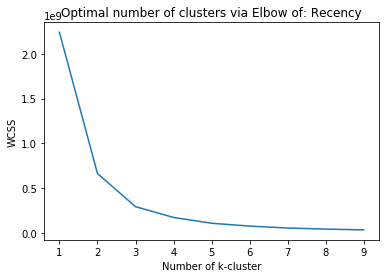

In [63]:
sort_orders = [False, True, True]
names = ['Recency','Frequency','Revenue']
dfs = [df_recency, df_frequency, df_revenue]

for i in range(len(['Recency','Frequency','Revenue'])):
    df = pd.merge(df, dfs[i], on='customer_unique_id')
    kmeans = KMeans(n_clusters=4)
    
    if names[i] == "Recency":
        plot_cluster(df[[names[i]]], names[i])
        
    kmeans.fit(df[[names[i]]])
    df['cluster_' + names[i]] = kmeans.predict(df[[names[i]]])
    df = order_cluster('cluster_' + names[i], names[i], df, sort_orders[i])
    
#df['OverallScore'] = df['cluster_Recency'] + df['cluster_Frequency'] + df['cluster_Revenue']

The overall score is now calculated by adding the three dimensions together.

In [64]:
df['OverallScore'] = df['cluster_Recency'] + df['cluster_Frequency'] + df['cluster_Revenue']
df['OverallScore'].unique()

array([0, 2, 3, 1, 4, 5, 6, 7, 8])

Now the final table is made where there is grouped by OverallScore by taking the mean value for the three dimensions.
Furthermore, a count columns is added to see the distribution of customers for each score.

In [65]:
overview = df.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()
overview['Count'] = df.groupby('OverallScore')['customer_unique_id'].count()

overview

,Recency,Frequency,Revenue,Count
OverallScore,,,,
0,488.052437,1.000000,91.226427,13254
1,341.729491,1.008579,120.359379,22380
2,217.250292,1.019169,142.400327,26501
3,101.704155,1.028977,167.217496,25848
4,97.551161,1.147089,401.978889,5942
5,88.401038,1.439585,779.857279,1349
6,77.028689,1.840164,1533.397623,244
7,104.666667,3.545455,1140.622424,33
8,52.888889,6.666667,1610.453333,9


It can be seen from the table that the 9 score numbers have a very imbalanced amount of customers between them. As the customers are receiving a higher score, the fewer and fewer amount of customers there is. The customers achieving the best possible score, 8, are only 9 out of 95560 customers. In the distribution of returning customers in the data visualisation part of the notebook, we saw that Olist was really struggling with non having enough returning customers. This is also outlines in the table above where it is first after score 6 where we have customers who all are returning more than 1 time. 

The segments are divided into three categories: 

- Low Value: 0
- Mid Value: 1,2,3
- High Value: 4,5,6,7,8



In [66]:
df['Segment'] = 'Low-Value'
df.loc[df['OverallScore']>1,'Segment'] = 'Mid-Value' 
df.loc[df['OverallScore']>3,'Segment'] = 'High-Value' 

Now the segments are distributed on a scatter plot below.


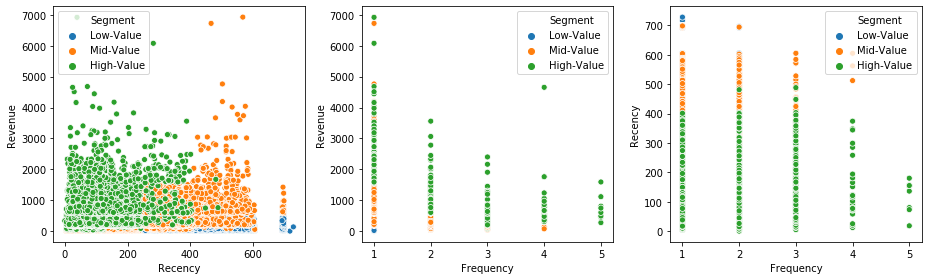

In [67]:
plot = df[(df['Revenue']<7000) & (df['Frequency']<6)]

plt.figure(figsize=(13, 4))
    
ax0_names = ['Recency','Frequency','Frequency']
ax1_names = ['Revenue','Revenue','Recency']

for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(ax0_names[i], ax1_names[i], hue='Segment', data=plot)

plt.tight_layout()
plt.show()

The high-value customers and mid-value customers are quite seperated when looking at the three scatterplots. However, it seems like the low-value customers are very close to the mid-value customers. By taking a look at the scatter plot with Revenue and Recency, it can be seen that that the high and mid-value customers are seperated but the low-value customers seems to lie around the mid-value.
Furthermore, it is seen that for both of the frequency plots, the data lies on vertical lines which is due to frequency is an integer number ranging from 1 to 5. Again, the low-value customers are hard to seperate from the other categories in both of the plots. 


In the above part of the notebook, a RFM segmentation has been performed with K-means clustering. With this analysis, Olist can identify their most profitable customers. But more than that, it also tells Olist which customers to focus on keeping as loyal customers by for example giving them promotions and special offers. Furthermore, Olist can also use this analysis to identify their not so good customers, and use targeted marketing strategies to turn these customers to become more profitable. This can also be through special offers but also incentive programs to increase the amount of returning customers. With the defined RCF KPI, Olist can track their performance for the amount of retunring customers they have. Furthermore, they can set time dependent targets for when the business should have a RCF=10% and so on.


# Customer Lifetime Value

Now we know who our best customers are from our segmentation. Therefore, it is relevant to dive deeper into our customers and get an idea of how much value they are creating for Olist. 
Therefore we can use use the method, Customer Lifetime Value (CLV), which is  a prediction of the net profit attributed to a future relationship with a customer.
In this part of the workbook, we will go through the following path:

- Define a timeframe for CLV
- Identify relevant features used for modelling 
- Calculate the CLV to train the models
- Build a baseline model, and suggest more advanced model
- Evaluate the proposed models




Note: Since we do not have the net profit for each customer available in the data, we will use the revenue instead.






### Defining the timeframe for CLV and relevant features
We have chosen to predict the CLV for the next 8 months so the period will be from 01/10/2017 - 01/06/2018. 

We can use the RFM clustering for each customer as a feature to our prediction model. Therefore, we take 10 months of data to calculate the RFM and use it to predict the next 8 month CLV. The 10 months will stretch from 01/01/2017-01/10/2017. 

First, we will split the dataframe into two dataframes and append the RFM scores after.

In [68]:
from datetime import datetime, timedelta, date
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [69]:
# Create 10m and 8m dataframes
df_10m = cop[(cop.order_purchase_timestamp < pd.Timestamp(2017,10,1))\
             & (cop.order_purchase_timestamp >= pd.Timestamp(2017,1,1))].reset_index(drop=True)

df_8m = cop[(cop.order_purchase_timestamp >= pd.Timestamp(2017,10,1))\
            & (cop.order_purchase_timestamp < pd.Timestamp(2018,6,1))].reset_index(drop=True)

Calculating the RFM scores with the code from the segmentation for the 10-month period.

In [70]:
# Recency 10m
df_recency = df_10m.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_recency.columns = ['customer_unique_id','last_purchase_date']
df_recency['Recency'] = (df_recency['last_purchase_date'].max() - df_recency['last_purchase_date']).dt.days
df_recency = df_recency[['customer_unique_id','Recency']]

# Frequency 10m
df_frequency = df_10m.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_unique_id','Frequency']

# Revenue 10m
df_revenue = df_10m.groupby('customer_unique_id').payment_value.sum().reset_index()
df_revenue.columns = ['customer_unique_id','Revenue']

df_10 = pd.DataFrame(df_10m['customer_unique_id'].unique())
df_10.columns = ['customer_unique_id']

sort_orders = [False, True, True]
names = ['Recency','Frequency','Revenue']
dfs = [df_recency, df_frequency, df_revenue]

# Performing Kmeans clustering on recency, frequency and revenue
for i in range(len(['Recency','Frequency','Revenue'])):
    df_10 = pd.merge(df_10, dfs[i], on='customer_unique_id')
    kmeans = KMeans(n_clusters=4)        
    kmeans.fit(df_10[[names[i]]])
    df_10['cluster_' + names[i]] = kmeans.predict(df_10[[names[i]]])
    df_10 = order_cluster('cluster_' + names[i], names[i], df_10, sort_orders[i])
    
df_10['OverallScore'] = df_10['cluster_Recency'] + df_10['cluster_Frequency'] + df_10['cluster_Revenue']

In [71]:
df_10['Segment'] = 'Low-CLV'
df_10.loc[df['OverallScore']>1,'Segment'] = 'Mid-CLV' 
df_10.loc[df['OverallScore']>3,'Segment'] = 'High-CLV' 

# Removing outliers
df_plot = df_10[(df_10['Revenue']<7000) & (df_10['Frequency']<6)]

### 8 month CLV

Now the 8 month CLV is calculated for each customer. We use the 8 month dataframe and groupby the unique customers and sum the value of their payments. The distribution for revenue is shown with a histogram. 
The histogram shows, as expected, that most of the customers are creating a low amount of revenue and it is a very small part of the customers that creating a total revenue above 300 BRL. 

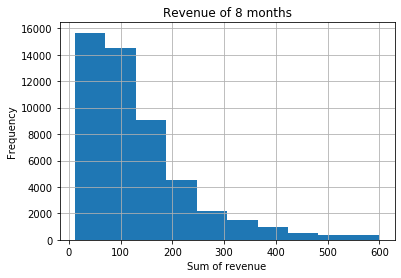

In [72]:
# Calculate revenue and create a new dataframe for it
df_8 = df_8m.groupby('customer_unique_id')['payment_value'].sum().reset_index()
df_8.columns = ['customer_unique_id','m8_Revenue']

# Plotting
df_8['m8_Revenue'][df_8['m8_Revenue']<600].hist()
plt.ylabel('Frequency')
plt.xlabel('Sum of revenue')
plt.title('Revenue of 8 months')
plt.show()

Now the target variabel, CLV, has been calculated for the 8-month dataset and the RFM features for the 10-month dataset. The two dataframes will now be merged so the correlation between the CLV and the features can be investigated. The CLV is continous variabel now which will be transformed to a categorial variabel by predicting three groups based on the CLV value. K-Means is again used for this segmentation.

In [73]:
df_merge = pd.merge(df_10, df_8, on='customer_unique_id', how='left')
#df_merge = df_merge.fillna(0)

df_merge.head()
#insert scatter plot her af RFM score vs 8m LTV

,customer_unique_id,Recency,cluster_Recency,Frequency,cluster_Frequency,Revenue,cluster_Revenue,OverallScore,Segment,m8_Revenue
0,861eff4711a542e4b93843c6dd7febb0,137,1,1,0,146.87,0,1,Low-CLV,NaN
1,7f3a72e8f988c6e735ba118d54f47458,142,1,1,0,102.03,0,1,Low-CLV,NaN
2,4390ddbb6276a66ff1736a6710205dca,169,1,1,0,94.63,0,1,Low-CLV,NaN
3,2e6a42a9b5cbb0da62988694f18ee295,138,1,1,0,47.59,0,1,Low-CLV,NaN
4,fd2d5fdb84e65fa6b54b98b0e2df5645,131,1,1,0,80.57,0,1,Low-CLV,NaN


In [74]:
#remove outliers
df_merge = df_merge[df_merge['m8_Revenue']<df_merge['m8_Revenue'].quantile(0.99)]

#creating 3 clusters
km = KMeans(n_clusters=3)
km.fit(df_merge[['m8_Revenue']])
df_merge['cluster_CLV'] = km.predict(df_merge[['m8_Revenue']])

#order cluster number based on LTV
df_merge = order_cluster('cluster_CLV', 'm8_Revenue', df_merge, True)

#creating a new cluster dataset
df_cluster = df_merge.copy()

#basic statistics for the clusters
df_cluster.groupby('cluster_CLV')['m8_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_CLV,,,,,,,,
0,388.0,93.216366,43.829355,15.89,55.3075,88.655,130.8775,180.51
1,100.0,273.550100,63.001244,184.73,220.8700,267.305,314.3375,435.95
2,22.0,610.989091,98.363437,453.80,543.2925,616.970,665.2375,785.24


Above the three CLV clusters are described. The problem with non-occuring customers are clearly seen here where the combined count of the clusters are 510. What is intersting to see is the distribution of customers in each category which is very imbalanced. The customers that are expected to give the least revenue, cluster 0, in the next 8 months accounts for 76% of the customers, cluster 1 acounts 19% and cluster 2 for 5%. 
In order to maximise revenue, Olist could use the `Customer Lifetime Value` KPI to set targets for the distribution to gain more high value customers e.g. set a target that by a certain date 10% of their customers should be in the best cluster. 


This is much to little data to use for a prediction model in order for it to create results which can be actually used in a business setting. 
However, we will still apply some basic predition models and a more advanced one. The results from these models might be useless but the concept of tracking the CLV for a customer and predicting a new customer's CLV can create a lot of value for Olist in the future. 

In [30]:
df_cluster.head()

,customer_unique_id,Recency,cluster_Recency,Frequency,cluster_Frequency,Revenue,cluster_Revenue,OverallScore,Segment,m8_Revenue,cluster_CLV
0,18e3d276253780b44b5b7bf83f6785ec,150,1,1,0,96.88,0,1,Low-CLV,71.97,0
1,49d1599dd80dedc213037342bbe43fd7,120,1,1,0,40.77,0,1,Low-CLV,77.80,0
2,2b952792a20f6076f6e7a9c6a27ade02,117,1,1,0,47.54,0,1,Low-CLV,82.60,0
3,f7d2fc6f0a2778f53d2a6bfc27bd0e8c,137,1,1,0,190.33,0,1,Low-CLV,179.86,0
4,cb4253d36367737b6baa4f8ca58fac62,108,1,1,0,83.14,0,1,Low-CLV,59.66,0


The categorial variables are converted into dummy/indicator variables using pandas get_dummies()-function. 
Furthermore, the correlation between the features and the target variables are shown in a list.

In [31]:
#convert categorical columns to numerical
df_dummies = pd.get_dummies(df_cluster, columns=['Segment'])

#calculate and show correlations
corr_matrix = df_dummies.corr()
corr_matrix['cluster_CLV'].sort_values(ascending=False)

cluster_CLV          1.000000
m8_Revenue           0.903187
cluster_Revenue      0.233570
Revenue              0.232252
cluster_Frequency    0.181156
Frequency            0.171613
OverallScore         0.147613
Segment_Mid-CLV      0.097847
cluster_Recency      0.045234
Recency             -0.048607
Segment_Low-CLV     -0.097847
Name: cluster_CLV, dtype: float64

Before we fit the prediction model, our data is scaled using the MinMaxScaler from sklearn. After the data is splitted into a test and train set. 

In [35]:
from sklearn.preprocessing import MinMaxScaler

#create X and y, X will be feature set and y is the label - LTV
X = df_dummies.drop(['customer_unique_id','cluster_CLV','m8_Revenue'],axis=1)
y = df_dummies['cluster_CLV']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=56)

### Dummy baseline

Having a high class imbalance we first create a baseline "dummy" classifier to later compare with a more advanced model. The dummy classifier predicts classes by using simple rules. The default setting is "stratified" meaning that the model makes predictions by respecting the training datas class disitrbution.

In [36]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

clf = DummyClassifier(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74        55
           1       0.14      0.12      0.13        16
           2       0.50      0.17      0.25         6

   micro avg       0.60      0.60      0.60        77
   macro avg       0.45      0.36      0.37        77
weighted avg       0.57      0.60      0.58        77



The dummy classifier performs well on the first cluster 0 but are struggling alot with cluster 1 and a bit with cluster 2. 

### Logistic regression 

A logistic regression model is also tried on the dataset. 

In [37]:
#class_weight='balanced' er til, skal vendes med Stannislav 
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial',class_weight='balanced').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.49      0.59        55
           1       0.28      0.44      0.34        16
           2       0.25      0.67      0.36         6

   micro avg       0.49      0.49      0.49        77
   macro avg       0.43      0.53      0.43        77
weighted avg       0.61      0.49      0.52        77



The overall performance level is similar to the dummy classifier. The Precision is twice as high for cluster 1 in logistic regression compared to the dummy classifier. However, the precision for cluster 2 is at the same time half as low compared to the dummy. 

In [38]:
clf.coef_

array([[ 0.58808132,  0.23549216, -0.21882155, -0.33255199, -1.38009096,
        -0.59043405, -0.21029251, -0.0119123 ,  0.01167866],
       [ 0.81625171, -0.10422958,  0.81272001,  1.30622988, -0.85634008,
         0.41354052,  0.63329742,  0.18885057, -0.18949584],
       [-1.40433303, -0.13126258, -0.59389847, -0.97367789,  2.23643104,
         0.17689353, -0.42300491, -0.17693827,  0.17781718]])

### ANN Classifier

With two simple models implemented, a more advanced model is proposed. The model is a feed-forward neural network with 2 layers with 20 hidden units in each layer. Relu is used as the non-linear activation function in both layers. A softmax function is applied to the outputlayer and categorical crossentropy is used as loss function. 
The model is trained with 100 epochs. 

In [41]:
# multi-class classification with Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

train_cat_y = np_utils.to_categorical(y_train)

# define baseline model
model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 
model.summary()
    
model.fit(X_train, train_cat_y, epochs = 10)    
y_pred = model.predict_classes(X_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                200       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 63        
Total params: 683
Trainable params: 683
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
433/433 [==============================] - 1s 3ms/step - loss: 1.2489 - accuracy: 0.0577
Epoch 2/10
433/433 [==============================] - 0s 243us/step - loss: 1.1392 - accuracy: 0.1778
Epoch 3/10
433/433 [==============================] - 0s 217us/step - loss: 1.0535 - accuracy: 0.6374
Epoch 4/10
433/433 [==============================] - 0s 308us/step - loss: 0.9842

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        55
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00         6

   micro avg       0.71      0.71      0.71        77
   macro avg       0.24      0.33      0.28        77
weighted avg       0.51      0.71      0.60        77



## Conclusion

From the classification report, it is clear that the advanced model are performning very poorly compared to the baseline models. The model is extremely naive and only prediciting the most frequent class (cluster 0) which results in a precision on 0 for both cluster 1 and 2. 
However, as stated above the results cannot be used in any business setting due to the low amount of data points. If Olist were to get more recurrent customers, this analysis could create a lot of value for the business because Olist would get an idea of which customers will create the most revenue in the future. 

When applying machine learning and deep learning methods, it is important to use cross validation in order to get a more accuratly result of how the model is going to perform in practice. Furthermore, methods such as Neural networks have a lot of hyper paramters that should be extensively optimised - which can be done either using premade functions such as gridsearch from Sklearn or writing functions that can do it. 
None of these things are done in this notebook which is again due to the low amount of data points. But it is worth mentioning because it would be much relevant for Olist Data science team to use if they were to gain more recurrent customers and use the above analysis.



This analysis has worked as a proof-of-concept for what actions Olist can do to become a more data-driven company that utilises the valuable data to take informed decisions. 
The analysis shows that using a customer segementation method such as RFM with K-means, clusters can be found seperating high-value, mid-value and low-value customers. This analysis can be used as a basis for new marketing campaigns where Olist can target customers at a more personal level.
Furthermore, by appling a customer lifetime value prediction model in a Olist business context enables Olist to focus their spending and staff ressources accordingly. 


In [75]:
#from sklearn.ensemble import RandomForestClassifier
#clf = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=0).fit(X_train, y_train)
#y_pred = clf.predict(X_test)
#print(classification_report(y_test, y_pred))